# FullClass-TrainCNN(InceptionV3)_NoFreezModel_No-ClassImbalance

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

## Training Set DIR

In [2]:
train_dataset_path='D:/DatasetMedicalWasteCropped/'

In [3]:
#train_dataset_path='D:/DatasetMedicalWasteCroppedBalancedOversamplingCopying/'

## Testing Set DIR

In [4]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [5]:
img_height=299
img_width=299
batch_size=64

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 3095 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 773 files for validation.


In [9]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [10]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [11]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


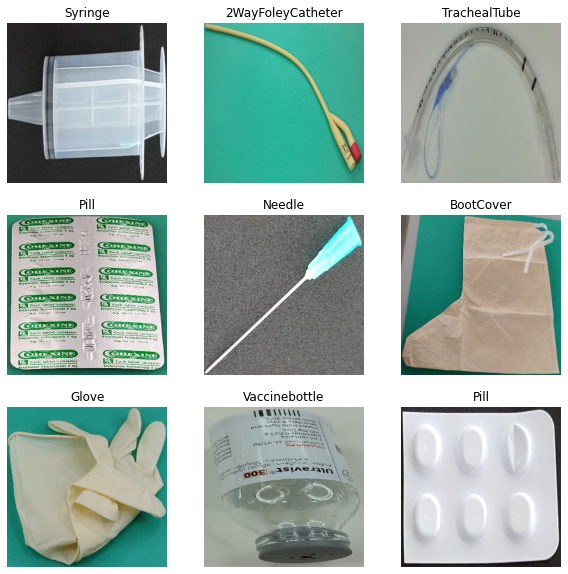

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

In [14]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=False)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 299, 299, 3)
(64,)


In [17]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

inceptionv3_model = keras.applications.InceptionV3(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

inceptionv3_model_nooutput = inceptionv3_model.layers[-2].output
custom_inceptionv3_model = Model(inputs = inceptionv3_model.input, outputs = inceptionv3_model_nooutput)
print(custom_inceptionv3_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [18]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_inceptionv3_model)
# Classifier
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 41)                84009     
Total params: 21,886,793
Trainable params: 21,852,361
Non-trainable params: 34,432
_________________________________________________________________


## Class Weight

In [20]:
y_train = np.concatenate([ y for x,y in train_ds],axis=0)

In [21]:
print(len(y_train))
print(y_train)

3095
[39 26  5 ...  7 18 19]


In [22]:
######################### Class Weight
from sklearn.utils import class_weight

# compute class weight 
# based on appearance of each class in y_trian
class_weight_value = class_weight.compute_class_weight(class_weight='balanced', classes=sorted(np.unique(y_train)), y=y_train)
# dict mapping
class_weight_value = {i : class_weight_value[i] for i, label in enumerate(sorted(np.unique(y_train)))}

# Fitting

In [3]:
path_to_model = 'D:/ModelMedicalWasteCheckpoint/Incepv3_OurOutputLayer-ClassWeight-NoAug-VerySlowLR/'

In [24]:
EPOCHS = 2000
save_model_interval = 20
checkpoint_filepath = path_to_model+'OurOutputLayer-ClassWeight-NoAug-epoch{epoch:04d}-val_acc{val_accuracy:.2f}.pb'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False,
    class_weight=class_weight_value)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr])

Epoch 1/2000
49/49 [==============================] - 49s 730ms/step - loss: 1.2072 - accuracy: 0.6879 - val_loss: 15.5167 - val_accuracy: 0.0142
Epoch 2/2000
49/49 [==============================] - 26s 535ms/step - loss: 0.3514 - accuracy: 0.8940 - val_loss: 4.6516 - val_accuracy: 0.3144
Epoch 3/2000
49/49 [==============================] - 26s 535ms/step - loss: 0.1829 - accuracy: 0.9438 - val_loss: 5.1840 - val_accuracy: 0.4411
Epoch 4/2000
49/49 [==============================] - 26s 535ms/step - loss: 0.1313 - accuracy: 0.9577 - val_loss: 1.3119 - val_accuracy: 0.7503
Epoch 5/2000
49/49 [==============================] - 26s 535ms/step - loss: 0.1167 - accuracy: 0.9635 - val_loss: 2.8547 - val_accuracy: 0.4748
Epoch 6/2000
49/49 [==============================] - 26s 536ms/step - loss: 0.1515 - accuracy: 0.9590 - val_loss: 1.7351 - val_accuracy: 0.5951
Epoch 7/2000
49/49 [==============================] - 26s 536ms/step - loss: 0.1458 - accuracy: 0.9564 - val_loss: 1.2304 - val_a

Text(0.5, 1.0, 'Training and Validation Accuracy')

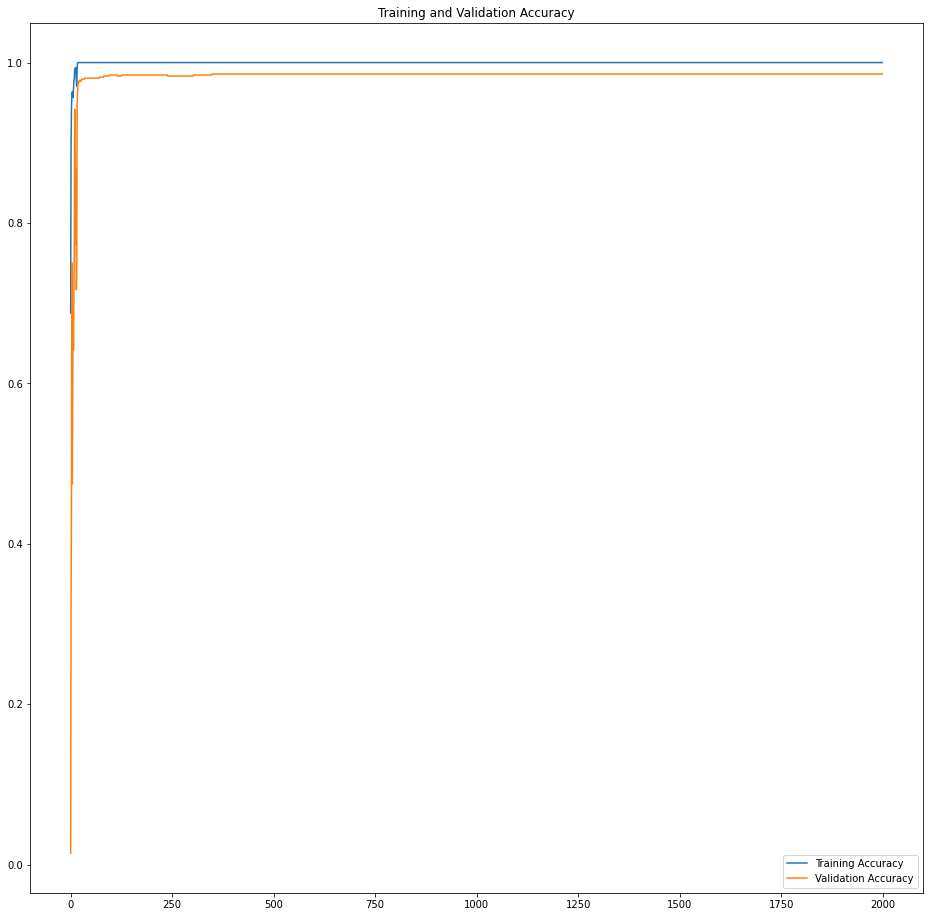

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


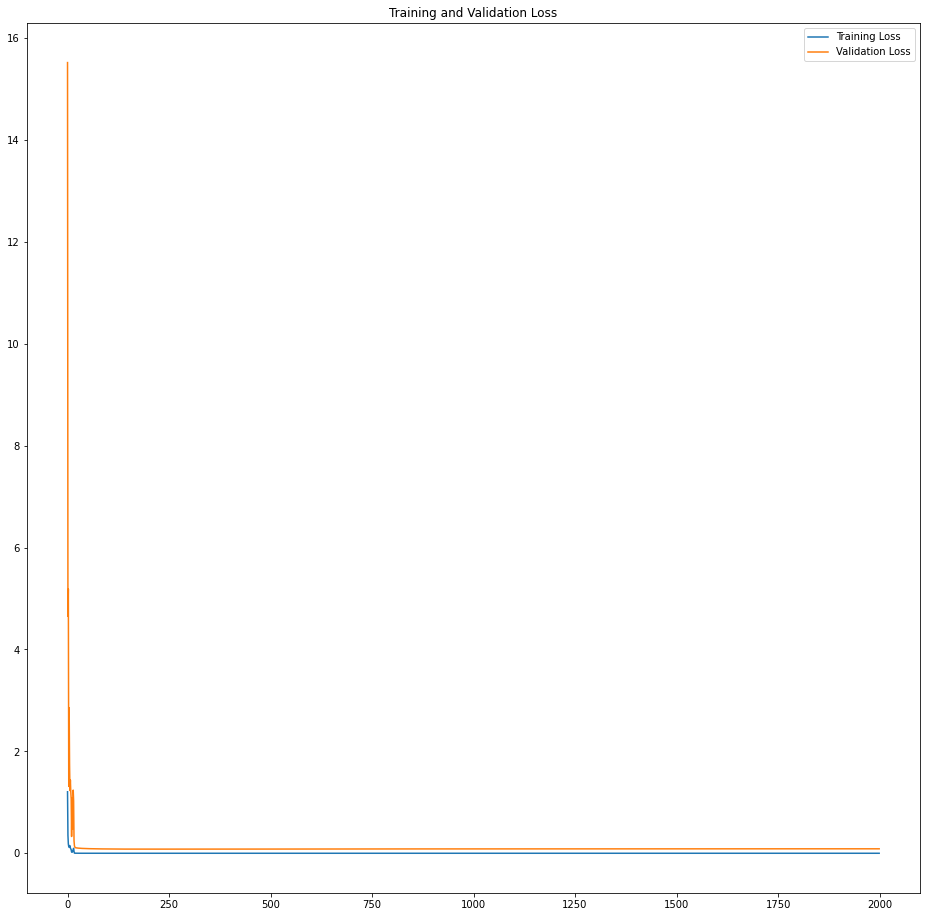

In [26]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 14s 355ms/step - loss: 4.4047 - accuracy: 0.5329
test_indoor_ds_results:test loss, test acc: [4.404655456542969, 0.5328873991966248]


In [28]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 27s 449ms/step - loss: 3.1567 - accuracy: 0.5678
test_outdoor_ds_results:test loss, test acc: [3.1567208766937256, 0.5678343772888184]


In [29]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 8s 201ms/step - loss: 1.4825 - accuracy: 0.7543
test_belt_ds_results:test loss, test acc: [1.48247230052948, 0.754306435585022]


In [30]:
# Read path of trained model
import os, os.path
trained_path = path_to_model
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/OurOutputLayer-ClassWeight-NoAug-VerySlowLR/OurOutputLayer-ClassWeight-NoAug-epoch0020-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-ClassWeight-NoAug-VerySlowLR/OurOutputLayer-ClassWeight-NoAug-epoch0040-val_acc0.98.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-ClassWeight-NoAug-VerySlowLR/OurOutputLayer-ClassWeight-NoAug-epoch0060-val_acc0.98.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-ClassWeight-NoAug-VerySlowLR/OurOutputLayer-ClassWeight-NoAug-epoch0080-val_acc0.98.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-ClassWeight-NoAug-VerySlowLR/OurOutputLayer-ClassWeight-NoAug-epoch0100-val_acc0.98.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-ClassWeight-NoAug-VerySlowLR/OurOutputLayer-ClassWeight-NoAug-epoch0120-val_acc0.98.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-ClassWeight-NoAug-VerySlowLR/OurOutputLayer-ClassWeight-NoAug-epoch0140-val_acc0.98.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutpu

# Testing in testset

In [31]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 5s 134ms/step - loss: 1.3800 - accuracy: 0.6949
Epoch020 
 test_indoor_acc=0.4687848389148712 
 test_outdoor_acc=0.49617835879325867 
 test_belt_acc=0.694922924041748
35/35 [==============================] - 5s 133ms/step - loss: 1.3346 - accuracy: 0.7135
Epoch040 
 test_indoor_acc=0.48272016644477844 
 test_outdoor_acc=0.5108280181884766 
 test_belt_acc=0.7135086059570312
35/35 [==============================] - 5s 130ms/step - loss: 1.3340 - accuracy: 0.7176
Epoch060 
 test_indoor_acc=0.48773691058158875 
 test_outdoor_acc=0.5171974301338196 
 test_belt_acc=0.7175884246826172
35/35 [==============================] - 5s 132ms/step - loss: 1.3374 - accuracy: 0.7239
Epoch080 
 test_indoor_acc=0.48885172605514526 
 test_outdoor_acc=0.5245223045349121 
 test_belt_acc=0.7239347100257874
35/35 [==============================] - 5s 130ms/step - loss: 1.3433 - accuracy: 0.7294
Epoch100 
 test_indoor_acc=0.4910813868045807 
 test_outdoor_acc=0.528025448

range(20, 2020, 20)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

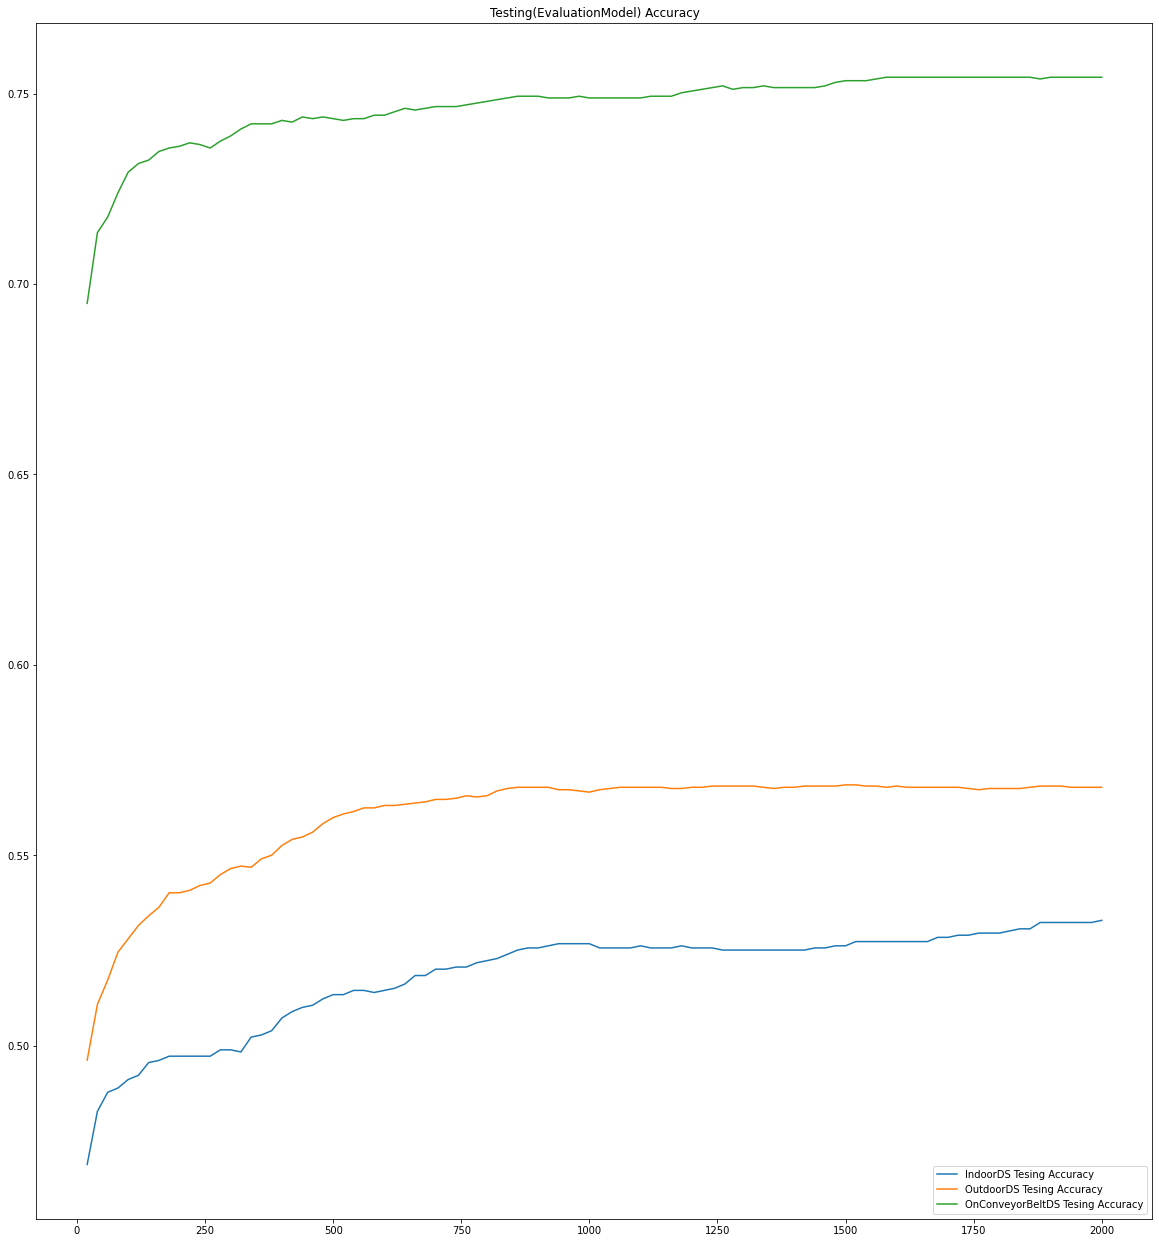

In [32]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

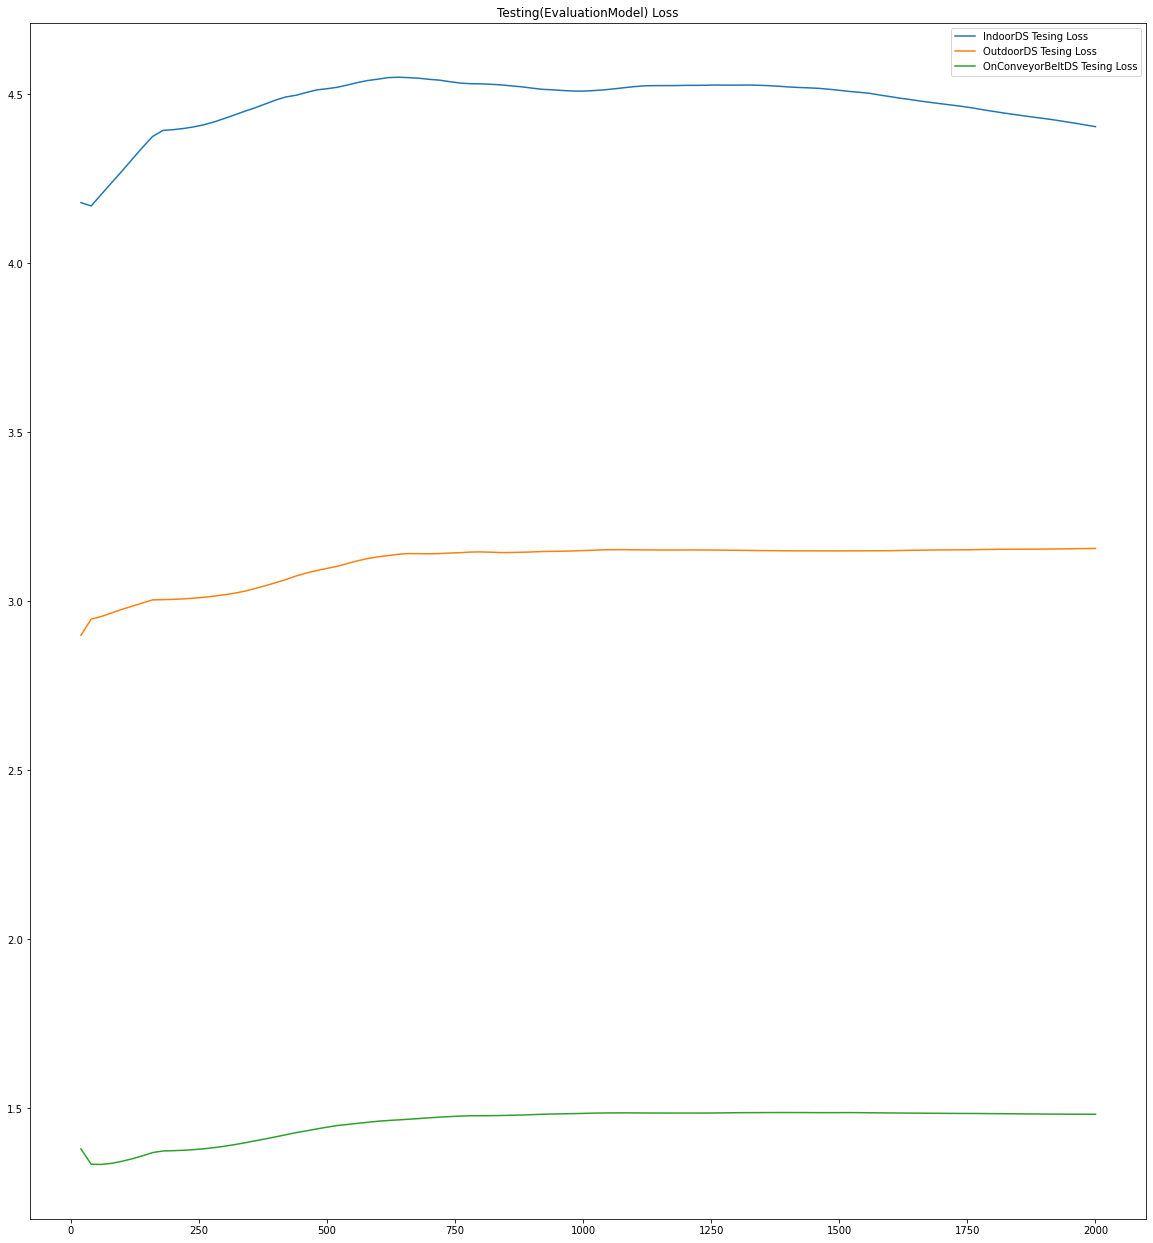

In [33]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [34]:
test_indoor_acc

[0.4687848389148712,
 0.48272016644477844,
 0.48773691058158875,
 0.48885172605514526,
 0.4910813868045807,
 0.4921962022781372,
 0.49554067850112915,
 0.4960981011390686,
 0.4972129464149475,
 0.4972129464149475,
 0.4972129464149475,
 0.4972129464149475,
 0.4972129464149475,
 0.4988851845264435,
 0.4988851845264435,
 0.49832776188850403,
 0.502229630947113,
 0.5027870535850525,
 0.5039018988609314,
 0.5072463750839233,
 0.5089186429977417,
 0.5100334286689758,
 0.5105908513069153,
 0.5122631192207336,
 0.5133779048919678,
 0.5133779048919678,
 0.5144927501678467,
 0.5144927501678467,
 0.5139353275299072,
 0.5144927501678467,
 0.5150501728057861,
 0.516165018081665,
 0.5183946490287781,
 0.5183946490287781,
 0.5200669169425964,
 0.5200669169425964,
 0.5206242799758911,
 0.5206242799758911,
 0.52173912525177,
 0.5222965478897095,
 0.5228539705276489,
 0.5239687561988831,
 0.525083601474762,
 0.5256410241127014,
 0.5256410241127014,
 0.5261984467506409,
 0.5267558693885803,
 0.5267558693

In [35]:
test_outdoor_acc

[0.49617835879325867,
 0.5108280181884766,
 0.5171974301338196,
 0.5245223045349121,
 0.5280254483222961,
 0.531528651714325,
 0.534076452255249,
 0.5363057255744934,
 0.5401273965835571,
 0.5401273965835571,
 0.540764331817627,
 0.5420382022857666,
 0.5426751375198364,
 0.5449044704437256,
 0.5464968085289001,
 0.54713374376297,
 0.5468152761459351,
 0.5490446090698242,
 0.550000011920929,
 0.5525477528572083,
 0.5541401505470276,
 0.5547770857810974,
 0.5560509562492371,
 0.5582802295684814,
 0.5598726272583008,
 0.5608280301094055,
 0.5614649653434753,
 0.5624203681945801,
 0.5624203681945801,
 0.5630573034286499,
 0.5630573034286499,
 0.5633757710456848,
 0.5636942386627197,
 0.5640127658843994,
 0.5646497011184692,
 0.5646497011184692,
 0.5649681687355042,
 0.565605103969574,
 0.5652866363525391,
 0.565605103969574,
 0.5668789744377136,
 0.5675159096717834,
 0.5678343772888184,
 0.5678343772888184,
 0.5678343772888184,
 0.5678343772888184,
 0.5671974420547485,
 0.5671974420547485,

In [36]:
test_belt_acc

[0.694922924041748,
 0.7135086059570312,
 0.7175884246826172,
 0.7239347100257874,
 0.7293744087219238,
 0.7316409945487976,
 0.7325475811958313,
 0.7348141670227051,
 0.7357207536697388,
 0.7361740469932556,
 0.7370806932449341,
 0.7366273999214172,
 0.7357207536697388,
 0.7375339865684509,
 0.7388939261436462,
 0.7407071590423584,
 0.7420670986175537,
 0.7420670986175537,
 0.7420670986175537,
 0.7429736852645874,
 0.7425203919410706,
 0.7438803315162659,
 0.743427038192749,
 0.7438803315162659,
 0.743427038192749,
 0.7429736852645874,
 0.743427038192749,
 0.743427038192749,
 0.7443336248397827,
 0.7443336248397827,
 0.7452402710914612,
 0.7461468577384949,
 0.745693564414978,
 0.7461468577384949,
 0.7466002106666565,
 0.7466002106666565,
 0.7466002106666565,
 0.7470535039901733,
 0.7475067973136902,
 0.747960090637207,
 0.7484134435653687,
 0.7488667368888855,
 0.7493200302124023,
 0.7493200302124023,
 0.7493200302124023,
 0.7488667368888855,
 0.7488667368888855,
 0.7488667368888855,

In [37]:
test_indoor_loss

[4.179967403411865,
 4.169979572296143,
 4.204648971557617,
 4.2388691902160645,
 4.272933483123779,
 4.308131694793701,
 4.342860698699951,
 4.375770568847656,
 4.393451690673828,
 4.3957109451293945,
 4.399143218994141,
 4.403933048248291,
 4.410270690917969,
 4.418702125549316,
 4.428873538970947,
 4.439501762390137,
 4.450384140014648,
 4.460460186004639,
 4.471936225891113,
 4.483308792114258,
 4.492543697357178,
 4.49760627746582,
 4.505823612213135,
 4.513306140899658,
 4.516846179962158,
 4.521062850952148,
 4.527824401855469,
 4.535157680511475,
 4.5412163734436035,
 4.545261383056641,
 4.549831390380859,
 4.550867080688477,
 4.549651145935059,
 4.547847270965576,
 4.544661045074463,
 4.542210102081299,
 4.537703037261963,
 4.533607482910156,
 4.531768321990967,
 4.531336307525635,
 4.530007362365723,
 4.528253555297852,
 4.525247573852539,
 4.522584438323975,
 4.518752574920654,
 4.51513671875,
 4.513760089874268,
 4.511587142944336,
 4.510089874267578,
 4.5097336769104,
 4.5

In [38]:
test_outdoor_loss

[2.8997631072998047,
 2.947404384613037,
 2.955406904220581,
 2.965958595275879,
 2.9763522148132324,
 2.985851764678955,
 2.9953079223632812,
 3.0044515132904053,
 3.005112409591675,
 3.0060362815856934,
 3.007420063018799,
 3.009450912475586,
 3.0121335983276367,
 3.015594005584717,
 3.0195724964141846,
 3.024327039718628,
 3.0303072929382324,
 3.038018226623535,
 3.0464847087860107,
 3.0552175045013428,
 3.0645744800567627,
 3.0752031803131104,
 3.0839362144470215,
 3.0911505222320557,
 3.0975687503814697,
 3.103713035583496,
 3.1120543479919434,
 3.1201155185699463,
 3.1269214153289795,
 3.1318836212158203,
 3.135558605194092,
 3.139492988586426,
 3.141451358795166,
 3.1411919593811035,
 3.1407833099365234,
 3.141584873199463,
 3.142995834350586,
 3.144205093383789,
 3.145916223526001,
 3.1464149951934814,
 3.1454925537109375,
 3.1444954872131348,
 3.1447699069976807,
 3.145423412322998,
 3.1462812423706055,
 3.1476032733917236,
 3.1480727195739746,
 3.1484694480895996,
 3.14932107

In [39]:
test_belt_loss

[1.380030870437622,
 1.3345884084701538,
 1.334026575088501,
 1.3373920917510986,
 1.3432872295379639,
 1.350756049156189,
 1.3594141006469727,
 1.3691315650939941,
 1.373896598815918,
 1.3746997117996216,
 1.3759613037109375,
 1.3777989149093628,
 1.3803975582122803,
 1.3837440013885498,
 1.3878997564315796,
 1.3926855325698853,
 1.3980554342269897,
 1.4038479328155518,
 1.4096629619598389,
 1.4156440496444702,
 1.4218783378601074,
 1.4280610084533691,
 1.4334847927093506,
 1.4390283823013306,
 1.4441946744918823,
 1.4491230249404907,
 1.452286958694458,
 1.4556005001068115,
 1.458791732788086,
 1.4619520902633667,
 1.4640969038009644,
 1.4658677577972412,
 1.4678388833999634,
 1.4698163270950317,
 1.4720137119293213,
 1.4739621877670288,
 1.4755983352661133,
 1.477074384689331,
 1.4780513048171997,
 1.478156328201294,
 1.4783674478530884,
 1.4788694381713867,
 1.4795312881469727,
 1.4802504777908325,
 1.4813672304153442,
 1.482490062713623,
 1.483252763748169,
 1.4837619066238403,
 1

## Load Last Epoch and test in each class

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

last_epoch_model = tf.keras.models.load_model(path_to_model+'OurOutputLayer-ClassWeight-NoAug-epoch2000-val_acc0.99.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=299
img_width=299
batch_size=64

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)}")
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)}")
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)}")
x_all = np.concatenate([x_test_indoor,x_test_outdoor,x_test_belt],axis=0)
y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
y_all_predicted = last_epoch_model.predict(x_all,batch_size=128)

Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794
train_outdoor num x,y : 3140,3140
train_belt num x,y : 2206,2206
all num x,y :7140,7140


In [5]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=4403
FP=2737
acc=0.6166666666666667
all check = 7140


In [6]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


1WayConnectorforFoley acc = 66.37931034482759%
2WayConnectorforFoley acc = 69.38775510204081%
2WayFoleyCatheter acc = 45.52238805970149%
3WayConnectorforFoley acc = 85.47008547008546%
3Waystopcock acc = 84.68468468468468%
AlcoholBottle acc = 77.5%
AlcoholPad acc = 47.61904761904761%
BootCover acc = 60.8433734939759%
CottonBall acc = 85.62874251497006%
CottonSwap acc = 49.65034965034965%
Dilator acc = 67.52136752136752%
DisposableInfusionSet acc = 35.39823008849557%
ExtensionTube acc = 30.89430894308943%
FaceShield acc = 46.913580246913575%
FrontLoadSyringe acc = 23.008849557522122%
GauzePad acc = 53.40909090909091%
Glove acc = 67.55952380952381%
GuideWire acc = 25.892857142857146%
LiquidBottle acc = 49.23664122137404%
Mask acc = 93.24675324675324%
NGTube acc = 34.193548387096776%
NasalCannula acc = 46.902654867256636%
Needle acc = 78.21428571428571%
OxygenMask acc = 53.383458646616546%
PPESuit acc = 80.64516129032258%
PharmaceuticalProduct acc = 55.140186915887845%
Pill acc = 91.036414

In [7]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[ 77,   0,   2, ...,   0,   0,   0],
       [  1, 102,   1, ...,   0,   0,   0],
       [  0,   0,  61, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  19,  15,   0],
       [  1,   0,   1, ...,   0, 155,   0],
       [  0,   0,  13, ...,   0,   0,  35]], dtype=int64)

In [8]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[66.37931034,  0.        ,  1.72413793, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.68027211, 69.3877551 ,  0.68027211, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 45.52238806, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 15.83333333,
        12.5       ,  0.        ],
       [ 0.46948357,  0.        ,  0.46948357, ...,  0.        ,
        72.76995305,  0.        ],
       [ 0.        ,  0.        , 11.40350877, ...,  0.        ,
         0.        , 30.70175439]])

<AxesSubplot:>

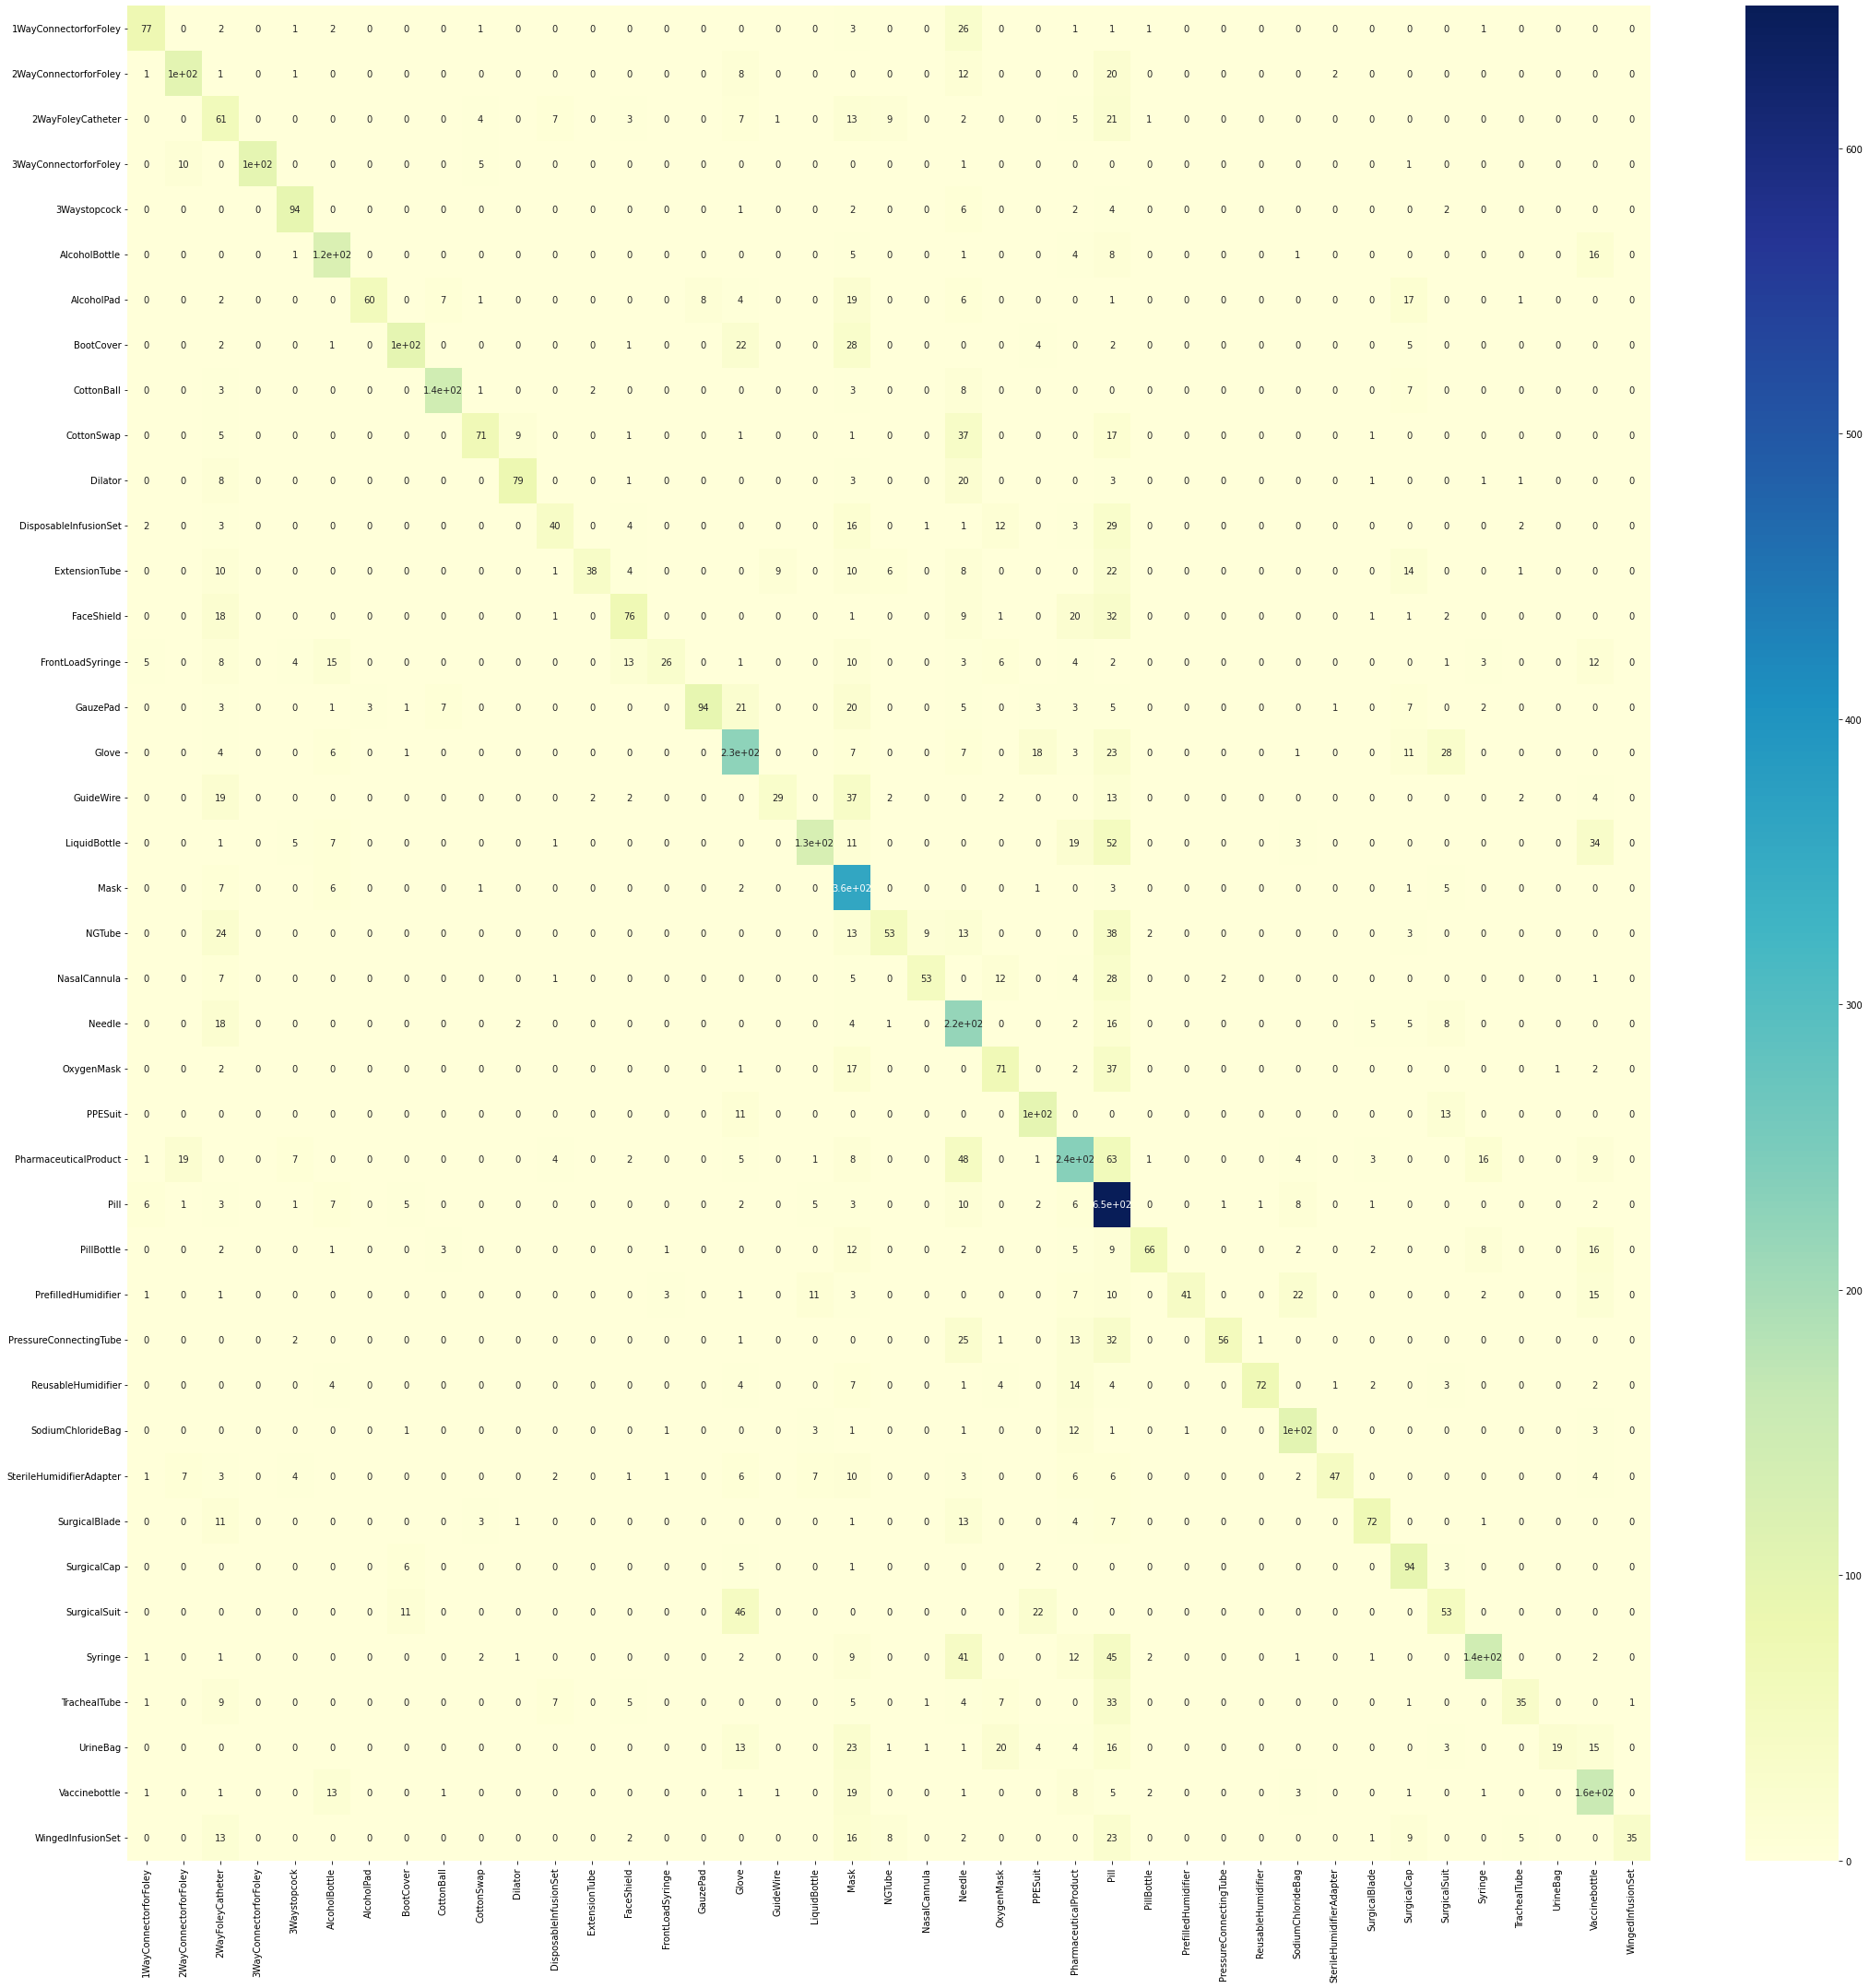

In [9]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")

<AxesSubplot:>

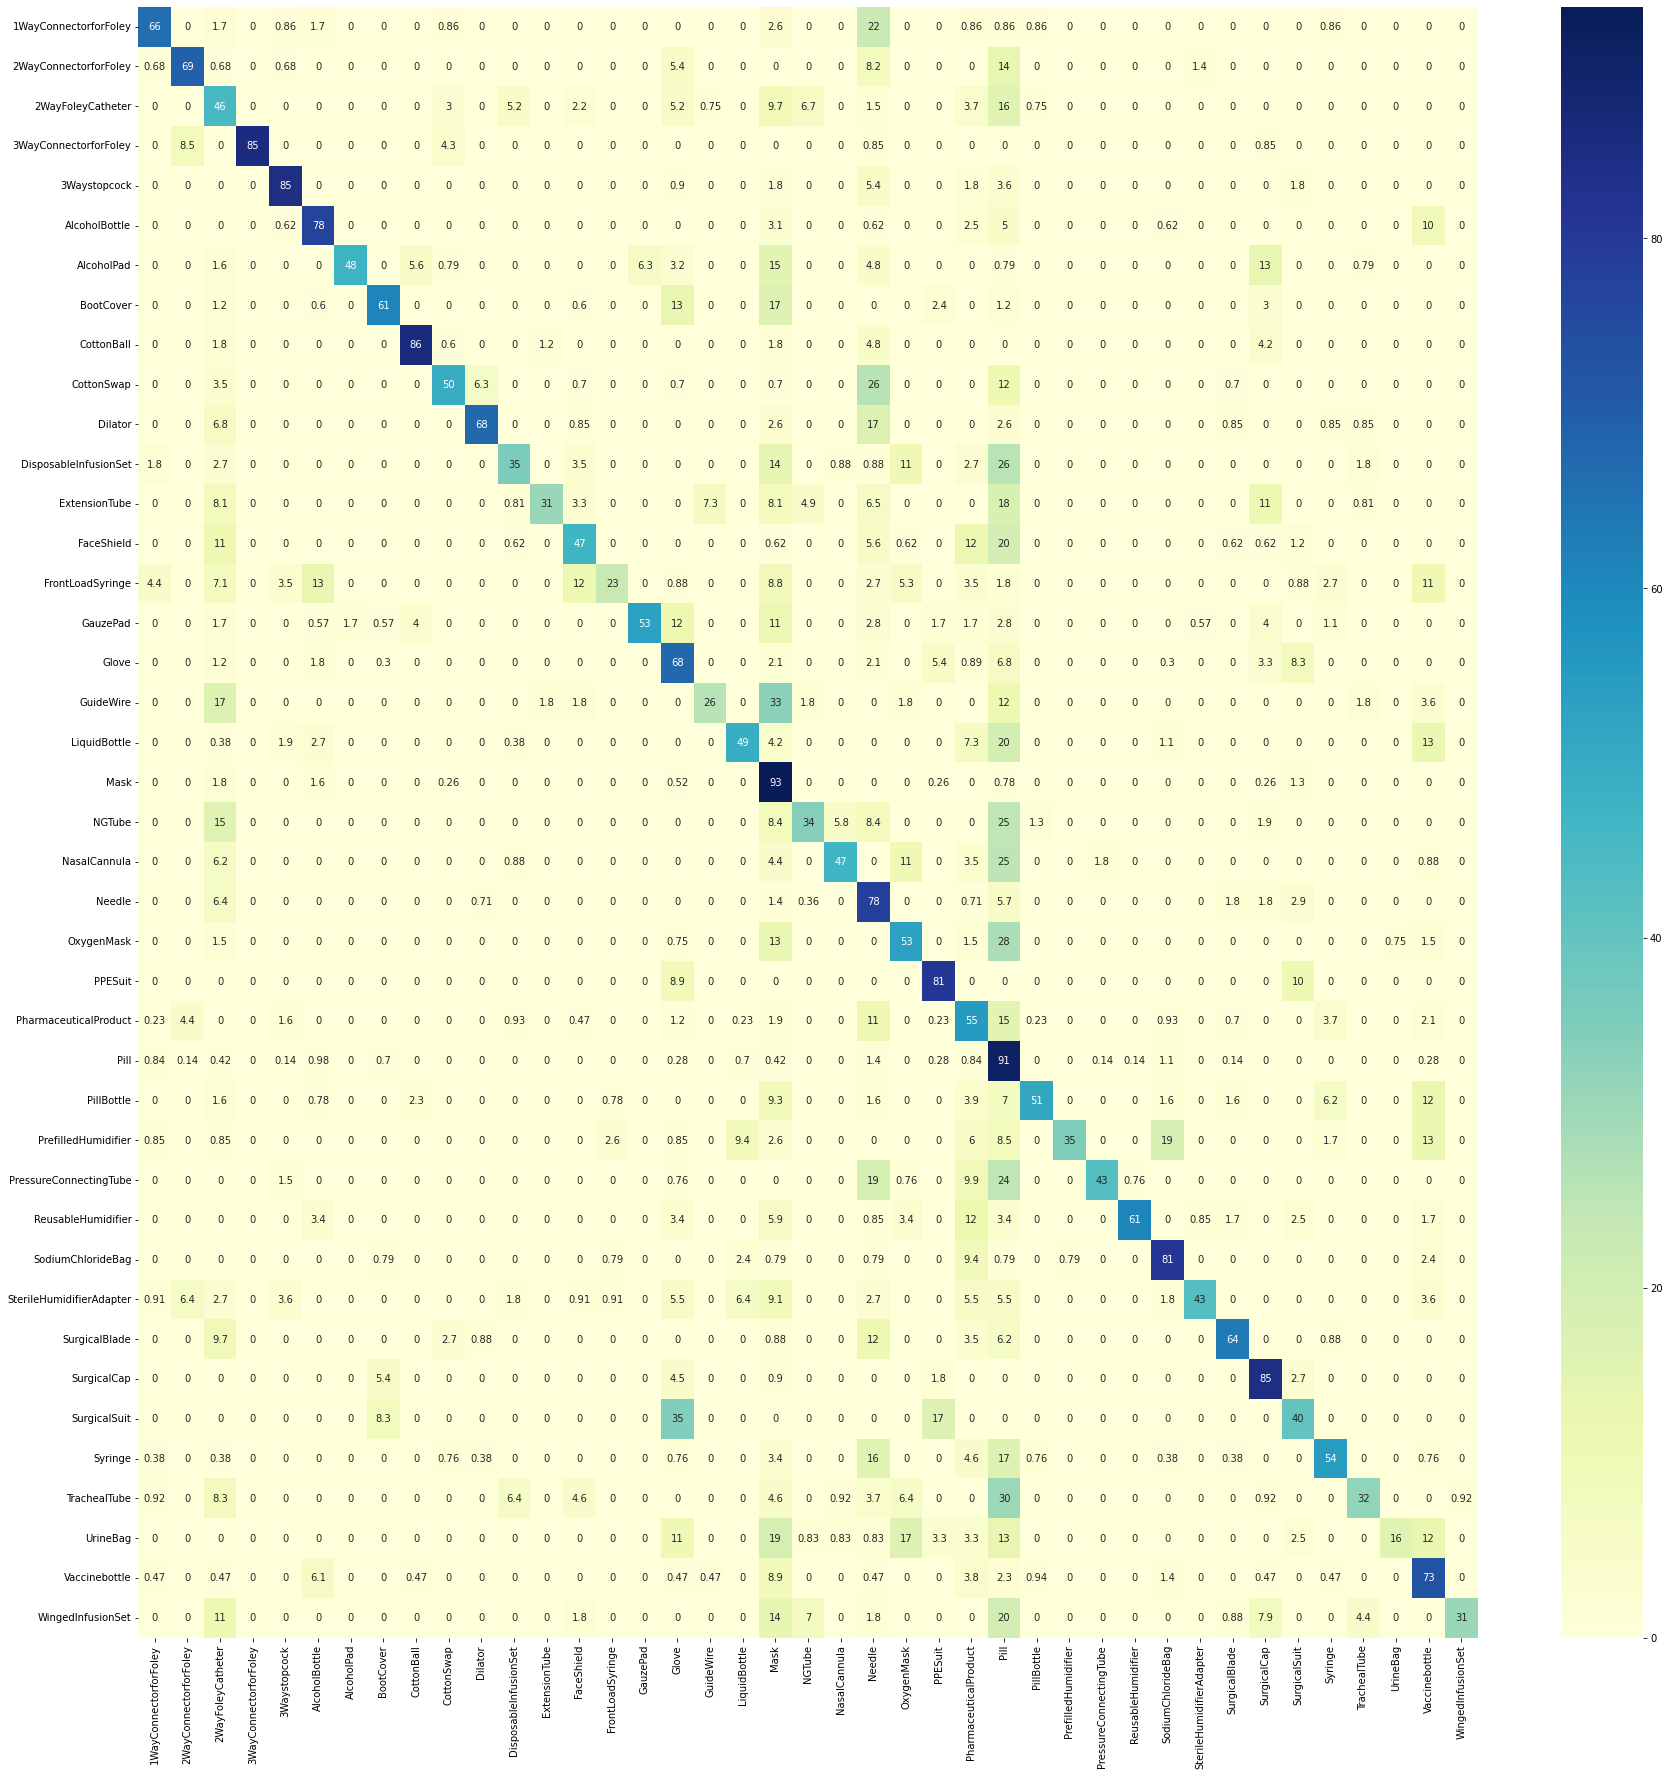

In [10]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")